In [30]:
from datasets import load_dataset
import json
import os
from pathlib import Path

from utils import measure_accuracy, read_jsonl, LABEL_NAMES_MAP


train_file = '/Users/ryanarman/code/lab/banking77/notebooks/data/banking77_synth_train.jsonl'
train_data = read_jsonl(train_file)
# val_file = '/Users/ryanarman/code/lab/banking77/notebooks/data/banking77_synth_val.jsonl'
# val_data = read_jsonl(val_file)
# test_file = '/Users/ryanarman/code/lab/banking77/notebooks/data/banking77_synth_test.jsonl'
# test_data = read_jsonl(test_file)

label_names = [LABEL_NAMES_MAP[label] for label in range(77)]

In [34]:


train_split = train_data

print(f"Train split size: {len(train_split)}")


# Prepare test set

train_texts = [item["messages"][0]['content'] for item in train_data]
train_labels = [int(item["messages"][1]['content']) for item in train_data]

print(f"Test set size: {len(train_texts)}")
print(f"Sample text: {train_texts[0]}")
print(f"Sample label: {label_names[train_labels[0]]}")


Train split size: 8000
Test set size: 8000
Sample text: Hi — I tried to top up my account with my Visa debit card but the payment keeps getting declined; can you check what’s wrong and tell me if there are limits or extra verification required?
Sample label: topping_up_by_card


# Visualize disributions

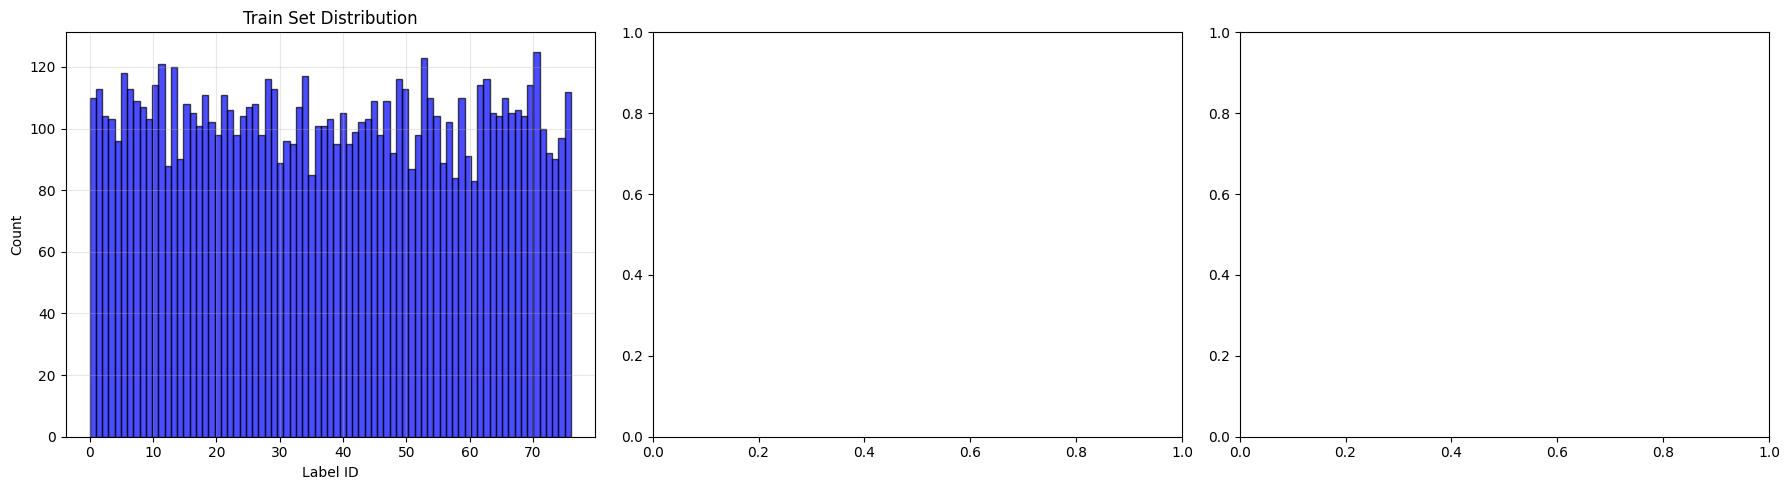


Distribution Statistics

Train Set:
  Total samples: 8000
  Unique labels: 77
  Min count per label: 83
  Max count per label: 125
  Mean count per label: 103.9
  Std count per label: 9.5


In [39]:
import matplotlib.pyplot as plt
import numpy as np
from collections import Counter

# Extract labels from each split
train_labels = [int(item["messages"][1]['content']) for item in train_data]

# Calculate label distributions
train_counts = Counter(train_labels)

# Get all unique labels (0-76)
all_labels = sorted(set(train_labels))

# Create figure with subplots - 1 row, 3 columns for histograms
fig, axes = plt.subplots(1, 3, figsize=(18, 5))

# Histogram comparison - side by side (three separate histograms)
# Order: Train | Validation | Test
ax1 = axes[0]  # Train
ax1.hist(train_labels, bins=77, alpha=0.7, color='blue', edgecolor='black')
ax1.set_xlabel('Label ID')
ax1.set_ylabel('Count')
ax1.set_title('Train Set Distribution')
ax1.grid(True, alpha=0.3)



plt.tight_layout()
plt.show()

# Calculate statistics for text output
train_counts_list = [train_counts.get(label, 0) for label in all_labels]

# Print distribution statistics
print("\n" + "="*60)
print("Distribution Statistics")
print("="*60)
print(f"\nTrain Set:")
print(f"  Total samples: {len(train_labels)}")
print(f"  Unique labels: {len(train_counts)}")
print(f"  Min count per label: {min(train_counts_list)}")
print(f"  Max count per label: {max(train_counts_list)}")
print(f"  Mean count per label: {np.mean(train_counts_list):.1f}")
print(f"  Std count per label: {np.std(train_counts_list):.1f}")





# Create system prompt

In [41]:
# Extract few-shot examples from training data
# This ensures we use real examples from the training distribution
def get_examples_for_labels(dataset_split, label_names, label_name_list, num_examples=3):
    """Get real examples from the dataset for specified labels.
    
    Args:
        dataset_split: The dataset split to search (train_split)
        label_names: List of all label names
        label_name_list: List of label names to find examples for
        num_examples: Number of examples to return per label
    
    Returns:
        Dict mapping label_name -> list of example texts
    """
    examples = {}
    for label_name in label_name_list:
        try:
            label_id = label_names.index(label_name)
            # Filter dataset for this label - new format uses messages[1]['content'] for label
            label_examples = [item for item in dataset_split if int(item["messages"][1]['content']) == label_id]
            # Take up to num_examples - new format uses messages[0]['content'] for text
            examples[label_name] = [item["messages"][0]['content'] for item in label_examples[:num_examples]]
        except ValueError:
            examples[label_name] = []
    return examples

# Get examples from training data
few_shot_data = get_examples_for_labels(
    train_split, 
    label_names,
    ["card_arrival", "card_delivery_estimate", "card_linking", "activate_my_card", "lost_or_stolen_card", "getting_virtual_card"],
    num_examples=3
)

print("Few-shot examples extracted from training data:")
for label, examples in few_shot_data.items():
    print(f"  {label}: {len(examples)} examples")
    if examples:
        print(f"    - {examples[0][:80]}...")


Few-shot examples extracted from training data:
  card_arrival: 3 examples
    - Hi, I requested a replacement debit card 10 business days ago and still haven’t ...
  card_delivery_estimate: 3 examples
    - Hi — I ordered a replacement debit card three business days ago; can you tell me...
  card_linking: 3 examples
    - Hi, I received a replacement debit card — can you help me link it to my online b...
  activate_my_card: 3 examples
    - Hi, I just received my new debit card in the mail — can you help me activate it?...
  lost_or_stolen_card: 3 examples
    - Hi — I can’t find my debit card and I think it was stolen after I used it at a g...
  getting_virtual_card: 3 examples
    - Hi, I want to get a virtual card linked to my checking account for online purcha...


In [43]:
# Create a system prompt for intent classification using numeric IDs
# Using IDs is more reliable and easier to parse than label names
from typing import Optional

# Create the ID mapping string
id_mapping_lines = [f"{i}: {label}" for i, label in enumerate(label_names)]
id_mapping = "\n".join(id_mapping_lines)

# Find IDs for few-shot examples
def get_label_id(label_name: str) -> Optional[int]:
    """Get the numeric ID for a label name."""
    try:
        return label_names.index(label_name)
    except ValueError:
        return None

# Get IDs for common confusing pairs
card_arrival_id = get_label_id("card_arrival")
card_delivery_estimate_id = get_label_id("card_delivery_estimate")
card_linking_id = get_label_id("card_linking")
activate_my_card_id = get_label_id("activate_my_card")
lost_or_stolen_card_id = get_label_id("lost_or_stolen_card")
getting_virtual_card_id = get_label_id("getting_virtual_card")

# Create few-shot examples using REAL examples from training data (not hardcoded)
few_shot_examples = ""
if all(id is not None for id in [card_arrival_id, card_delivery_estimate_id, card_linking_id, activate_my_card_id, lost_or_stolen_card_id, getting_virtual_card_id]):
    # Use the examples extracted from training data in the previous cell
    card_arrival_examples = few_shot_data.get("card_arrival", [])
    card_delivery_estimate_examples = few_shot_data.get("card_delivery_estimate", [])
    card_linking_examples = few_shot_data.get("card_linking", [])
    activate_my_card_examples = few_shot_data.get("activate_my_card", [])
    lost_or_stolen_card_examples = few_shot_data.get("lost_or_stolen_card", [])
    getting_virtual_card_examples = few_shot_data.get("getting_virtual_card", [])
    
    # Get additional examples for other confusing pairs identified in error analysis
    additional_labels = [
        "pin_blocked", "change_pin", "pending_cash_withdrawal", "declined_cash_withdrawal",
        "cash_withdrawal_not_recognised", "verify_my_identity", "why_verify_identity",
        "unable_to_verify_identity", "card_payment_wrong_exchange_rate",
        "wrong_exchange_rate_for_cash_withdrawal", "exchange_rate", "extra_charge_on_statement",
        "card_payment_fee_charged"
    ]
    additional_few_shot_data = get_examples_for_labels(train_split, label_names, additional_labels, num_examples=3)
    
    # Get IDs for additional confusing pairs
    pin_blocked_id = get_label_id("pin_blocked")
    change_pin_id = get_label_id("change_pin")
    pending_cash_withdrawal_id = get_label_id("pending_cash_withdrawal")
    declined_cash_withdrawal_id = get_label_id("declined_cash_withdrawal")
    cash_withdrawal_not_recognised_id = get_label_id("cash_withdrawal_not_recognised")
    verify_my_identity_id = get_label_id("verify_my_identity")
    why_verify_identity_id = get_label_id("why_verify_identity")
    unable_to_verify_identity_id = get_label_id("unable_to_verify_identity")
    card_payment_wrong_exchange_rate_id = get_label_id("card_payment_wrong_exchange_rate")
    wrong_exchange_rate_for_cash_withdrawal_id = get_label_id("wrong_exchange_rate_for_cash_withdrawal")
    exchange_rate_id = get_label_id("exchange_rate")
    extra_charge_on_statement_id = get_label_id("extra_charge_on_statement")
    card_payment_fee_charged_id = get_label_id("card_payment_fee_charged")
    
    # Build few-shot examples section using REAL examples from training data
    examples_lines = ["EXAMPLES TO HELP DISTINGUISH SIMILAR INTENTS:", ""]
    
    # 1. card_arrival vs card_delivery_estimate (CRITICAL - many errors here)
    # Key distinction: card_arrival = asking about YOUR specific card that hasn't arrived
    #                  card_delivery_estimate = asking about general delivery timeframes
    if card_arrival_examples and card_delivery_estimate_examples:
        examples_lines.append(f"1. card_arrival (ID {card_arrival_id}) vs card_delivery_estimate (ID {card_delivery_estimate_id}):")
        examples_lines.append(f"   card_arrival = asking about YOUR specific card that hasn't arrived yet (tracking, status)")
        examples_lines.append(f"   card_delivery_estimate = asking about general delivery timeframes/how long it takes")
        for ex in card_arrival_examples[:3]:  # Use 3 examples to emphasize
            examples_lines.append(f'   - Query: "{ex}" → {card_arrival_id}')
        for ex in card_delivery_estimate_examples[:3]:  # Use 3 examples
            examples_lines.append(f'   - Query: "{ex}" → {card_delivery_estimate_id}')
        examples_lines.append("")
    
    # 2. card_linking vs activate_my_card vs lost_or_stolen_card
    if card_linking_examples and activate_my_card_examples and lost_or_stolen_card_examples:
        examples_lines.append(f"2. card_linking (ID {card_linking_id}) vs activate_my_card (ID {activate_my_card_id}) vs lost_or_stolen_card (ID {lost_or_stolen_card_id}):")
        examples_lines.append(f"   card_linking = reconnecting a card you found/retrieved")
        examples_lines.append(f"   activate_my_card = activating a NEW card for first time")
        examples_lines.append(f"   lost_or_stolen_card = reporting a card as lost/stolen")
        for ex in card_linking_examples[:2]:
            examples_lines.append(f'   - Query: "{ex}" → {card_linking_id}')
        for ex in activate_my_card_examples[:2]:
            examples_lines.append(f'   - Query: "{ex}" → {activate_my_card_id}')
        for ex in lost_or_stolen_card_examples[:2]:
            examples_lines.append(f'   - Query: "{ex}" → {lost_or_stolen_card_id}')
        examples_lines.append("")
    
    # 3. pin_blocked vs change_pin
    if pin_blocked_id is not None and change_pin_id is not None:
        pin_blocked_examples = additional_few_shot_data.get("pin_blocked", [])
        change_pin_examples = additional_few_shot_data.get("change_pin", [])
        if pin_blocked_examples and change_pin_examples:
            examples_lines.append(f"3. pin_blocked (ID {pin_blocked_id}) vs change_pin (ID {change_pin_id}):")
            examples_lines.append(f"   pin_blocked = PIN is locked/blocked, need to unlock")
            examples_lines.append(f"   change_pin = want to change PIN to a new one")
            for ex in pin_blocked_examples[:2]:
                examples_lines.append(f'   - Query: "{ex}" → {pin_blocked_id}')
            for ex in change_pin_examples[:2]:
                examples_lines.append(f'   - Query: "{ex}" → {change_pin_id}')
            examples_lines.append("")
    
    # 4. pending_cash_withdrawal vs declined_cash_withdrawal vs cash_withdrawal_not_recognised
    if (pending_cash_withdrawal_id is not None and declined_cash_withdrawal_id is not None and 
        cash_withdrawal_not_recognised_id is not None):
        pending_cw_examples = additional_few_shot_data.get("pending_cash_withdrawal", [])
        declined_cw_examples = additional_few_shot_data.get("declined_cash_withdrawal", [])
        cw_not_rec_examples = additional_few_shot_data.get("cash_withdrawal_not_recognised", [])
        if pending_cw_examples and declined_cw_examples and cw_not_rec_examples:
            examples_lines.append(f"4. pending_cash_withdrawal (ID {pending_cash_withdrawal_id}) vs declined_cash_withdrawal (ID {declined_cash_withdrawal_id}) vs cash_withdrawal_not_recognised (ID {cash_withdrawal_not_recognised_id}):")
            examples_lines.append(f"   pending_cash_withdrawal = withdrawal is processing/pending")
            examples_lines.append(f"   declined_cash_withdrawal = withdrawal was rejected/declined")
            examples_lines.append(f"   cash_withdrawal_not_recognised = withdrawal not showing in account")
            for ex in pending_cw_examples[:1]:
                examples_lines.append(f'   - Query: "{ex}" → {pending_cash_withdrawal_id}')
            for ex in declined_cw_examples[:1]:
                examples_lines.append(f'   - Query: "{ex}" → {declined_cash_withdrawal_id}')
            for ex in cw_not_rec_examples[:1]:
                examples_lines.append(f'   - Query: "{ex}" → {cash_withdrawal_not_recognised_id}')
            examples_lines.append("")
    
    # 5. verify_my_identity vs why_verify_identity vs unable_to_verify_identity
    if (verify_my_identity_id is not None and why_verify_identity_id is not None and 
        unable_to_verify_identity_id is not None):
        verify_examples = additional_few_shot_data.get("verify_my_identity", [])
        why_verify_examples = additional_few_shot_data.get("why_verify_identity", [])
        unable_verify_examples = additional_few_shot_data.get("unable_to_verify_identity", [])
        if verify_examples and why_verify_examples and unable_verify_examples:
            examples_lines.append(f"5. verify_my_identity (ID {verify_my_identity_id}) vs why_verify_identity (ID {why_verify_identity_id}) vs unable_to_verify_identity (ID {unable_to_verify_identity_id}):")
            examples_lines.append(f"   verify_my_identity = want to verify/complete verification")
            examples_lines.append(f"   why_verify_identity = asking why verification is needed")
            examples_lines.append(f"   unable_to_verify_identity = having trouble completing verification")
            for ex in verify_examples[:1]:
                examples_lines.append(f'   - Query: "{ex}" → {verify_my_identity_id}')
            for ex in why_verify_examples[:1]:
                examples_lines.append(f'   - Query: "{ex}" → {why_verify_identity_id}')
            for ex in unable_verify_examples[:1]:
                examples_lines.append(f'   - Query: "{ex}" → {unable_to_verify_identity_id}')
            examples_lines.append("")
    
    # 6. Exchange rate related confusions
    if (card_payment_wrong_exchange_rate_id is not None and wrong_exchange_rate_for_cash_withdrawal_id is not None and
        exchange_rate_id is not None):
        card_payment_wrong_ex = additional_few_shot_data.get("card_payment_wrong_exchange_rate", [])
        cash_wrong_ex = additional_few_shot_data.get("wrong_exchange_rate_for_cash_withdrawal", [])
        exchange_rate_ex = additional_few_shot_data.get("exchange_rate", [])
        if card_payment_wrong_ex and cash_wrong_ex and exchange_rate_ex:
            examples_lines.append(f"6. card_payment_wrong_exchange_rate (ID {card_payment_wrong_exchange_rate_id}) vs wrong_exchange_rate_for_cash_withdrawal (ID {wrong_exchange_rate_for_cash_withdrawal_id}) vs exchange_rate (ID {exchange_rate_id}):")
            examples_lines.append(f"   card_payment_wrong_exchange_rate = wrong rate used for CARD payment")
            examples_lines.append(f"   wrong_exchange_rate_for_cash_withdrawal = wrong rate used for CASH withdrawal")
            examples_lines.append(f"   exchange_rate = asking about current/general exchange rates")
            for ex in card_payment_wrong_ex[:1]:
                examples_lines.append(f'   - Query: "{ex}" → {card_payment_wrong_exchange_rate_id}')
            for ex in cash_wrong_ex[:1]:
                examples_lines.append(f'   - Query: "{ex}" → {wrong_exchange_rate_for_cash_withdrawal_id}')
            for ex in exchange_rate_ex[:1]:
                examples_lines.append(f'   - Query: "{ex}" → {exchange_rate_id}')
            examples_lines.append("")
    
    # 7. Charge/fee related
    if extra_charge_on_statement_id is not None and card_payment_fee_charged_id is not None:
        extra_charge_ex = additional_few_shot_data.get("extra_charge_on_statement", [])
        card_fee_ex = additional_few_shot_data.get("card_payment_fee_charged", [])
        if extra_charge_ex and card_fee_ex:
            examples_lines.append(f"7. extra_charge_on_statement (ID {extra_charge_on_statement_id}) vs card_payment_fee_charged (ID {card_payment_fee_charged_id}):")
            examples_lines.append(f"   extra_charge_on_statement = unexpected charge on statement")
            examples_lines.append(f"   card_payment_fee_charged = fee charged for card payment")
            for ex in extra_charge_ex[:1]:
                examples_lines.append(f'   - Query: "{ex}" → {extra_charge_on_statement_id}')
            for ex in card_fee_ex[:1]:
                examples_lines.append(f'   - Query: "{ex}" → {card_payment_fee_charged_id}')
            examples_lines.append("")
    
    # 8. getting_virtual_card
    if getting_virtual_card_examples:
        examples_lines.append(f"8. getting_virtual_card (ID {getting_virtual_card_id}):")
        for ex in getting_virtual_card_examples[:2]:
            examples_lines.append(f'   - Query: "{ex}" → {getting_virtual_card_id}')
        examples_lines.append("")
    
    few_shot_examples = "\n".join(examples_lines) if len(examples_lines) > 2 else ""

system_prompt = f"""You are a banking intent classifier. Classify the user's query into one of  {num_labels} banking intents (output is a single integer ID).
                   
IDs:

{id_mapping}

CRITICAL INSTRUCTIONS:
1. Choose exactly one integer ID (0-{num_labels-1}).
2. Reply with ONLY that number. No words, no reasoning, no punctuation.
Examples: 0, 1, 42

EXAMPLES TO HELP DISTINGUISH SIMILAR INTENTS:
{few_shot_examples}

Remember: Respond with ONLY the numeric ID, nothing else."""

print("System prompt created with numeric IDs and few-shot examples")
print(f"Number of labels: {num_labels}")
print(f"ID range: 0-{num_labels-1}")


system_prompt_basic = f"""You are a banking intent classifier. Classify the user's query into one of  {num_labels} banking intents (output is a single integer ID).
                   
IDs:

{id_mapping}

CRITICAL INSTRUCTIONS:
1. Choose exactly one integer ID (0-{num_labels-1}).
2. Reply with ONLY that number. No words, no reasoning, no punctuation.
Examples: 0, 1, 42

Remember: Respond with ONLY the numeric ID, nothing else."""

print(system_prompt)

System prompt created with numeric IDs and few-shot examples
Number of labels: 77
ID range: 0-76
You are a banking intent classifier. Classify the user's query into one of  77 banking intents (output is a single integer ID).

IDs:

0: activate_my_card
1: age_limit
2: apple_pay_or_google_pay
3: atm_support
4: automatic_top_up
5: balance_not_updated_after_bank_transfer
6: balance_not_updated_after_cheque_or_cash_deposit
7: beneficiary_not_allowed
8: cancel_transfer
9: card_about_to_expire
10: card_acceptance
11: card_arrival
12: card_delivery_estimate
13: card_linking
14: card_not_working
15: card_payment_fee_charged
16: card_payment_not_recognised
17: card_payment_wrong_exchange_rate
18: card_swallowed
19: cash_withdrawal_charge
20: cash_withdrawal_not_recognised
21: change_pin
22: compromised_card
23: contactless_not_working
24: country_support
25: declined_card_payment
26: declined_cash_withdrawal
27: declined_transfer
28: direct_debit_payment_not_recognised
29: disposable_card_limits